<a href="https://colab.research.google.com/github/muhammadsajad/Automatic_lesion_detection_in_periapical_xrays/blob/main/Periapical_Xrays_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import random
from shutil import copyfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
# from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

How to use datasets from Kaggle on Google Colab using Kaggle API ? Watch this Video: https://www.youtube.com/watch?v=gwDOUuBH7ws

In [3]:
# Give the path of kaggle.jason file in order to download data directly from kaggle.
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

**1- Downloading dataset from Kaggle**

In [4]:
# This is the kaggle api of data set.
!kaggle datasets download -d muhammadsajad/periapical-xrays

 95% 145M/153M [00:02<00:00, 68.5MB/s]
100% 153M/153M [00:02<00:00, 70.0MB/s]


In [5]:
!unzip \*.zip && rm *.zip


Archive:  periapical-xrays.zip
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (10).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (100).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (101).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (102).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (103).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (104).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (105).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondary Perio (106).JPG  
  inflating: Periapical_Xrays/Primary Endo with Secondary Perio/Primary Endo with Secondar

# Display total number of images present in each category

In [6]:
# Display total number of images present in each category
source_path = '/content/Periapical_Xrays'

source_path_Primary_Endo_with_Secondary_Perio = os.path.join(source_path, 'Primary Endo with Secondary Perio')
source_path_Primary_Endodontic_Lesion = os.path.join(source_path, 'Primary Endodontic Lesion')
source_path_Primary_Perio_with_Secondary_Endo = os.path.join(source_path, 'Primary Perio with Secondary Endo')
source_path_Primary_Periodontal_Lesion = os.path.join(source_path, 'Primary Periodontal Lesion')
source_path_True_Combined_Lesions = os.path.join(source_path, 'True Combined Lesions')

# # Deletes all non-image files (there are two .db files bundled into the dataset)
# !find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_Primary_Endo_with_Secondary_Perio))} images of Primary Endo with Secondary Perio.")
print(f"There are {len(os.listdir(source_path_Primary_Endodontic_Lesion))} images of Primary Endodontic Lesion.")
print(f"There are {len(os.listdir(source_path_Primary_Perio_with_Secondary_Endo))} images of Primary Perio with Secondary Endo.")
print(f"There are {len(os.listdir(source_path_Primary_Periodontal_Lesion))} images of Primary Periodontal Lesion.")
print(f"There are {len(os.listdir(source_path_True_Combined_Lesions))} images of True Combined Lesions.")

There are 122 images of Primary Endo with Secondary Perio.
There are 124 images of Primary Endodontic Lesion.
There are 39 images of Primary Perio with Secondary Endo.
There are 118 images of Primary Periodontal Lesion.
There are 131 images of True Combined Lesions.




# Now we create two trianing and validation directories and in that directories creating subdirectories for each catogory/class.

In [7]:
import shutil
# Define root directory
root_dir = '/content/Xrays'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from


  """



  #This for creating training subdirectory
  parent_dir = root_path + "/training"
  path=os.path.join(parent_dir,'Primary Endo with Secondary Perio')
  os.makedirs(path)
  path=os.path.join(parent_dir,'Primary Endodontic Lesion')
  os.makedirs(path)
  path=os.path.join(parent_dir,'Primary Perio with Secondary Endo')
  os.makedirs(path)
  path=os.path.join(parent_dir,'Primary Periodontal Lesion')
  os.makedirs(path)
  path=os.path.join(parent_dir,'True Combined Lesions')
  os.makedirs(path)

  # This for creating validation subdirectory
  parent_dir=root_path + "/validation"
  path=os.path.join(parent_dir,'Primary Endo with Secondary Perio')
  os.makedirs(path)
  path=os.path.join(parent_dir,'Primary Endodontic Lesion')
  os.makedirs(path)
  path=os.path.join(parent_dir,'Primary Perio with Secondary Endo')
  os.makedirs(path)
  path=os.path.join(parent_dir,'Primary Periodontal Lesion')
  os.makedirs(path)
  path=os.path.join(parent_dir,'True Combined Lesions')
  os.makedirs(path)






try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [8]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/Xrays/validation
/content/Xrays/training
/content/Xrays/validation/Primary Periodontal Lesion
/content/Xrays/validation/Primary Perio with Secondary Endo
/content/Xrays/validation/Primary Endo with Secondary Perio
/content/Xrays/validation/True Combined Lesions
/content/Xrays/validation/Primary Endodontic Lesion
/content/Xrays/training/Primary Periodontal Lesion
/content/Xrays/training/Primary Perio with Secondary Endo
/content/Xrays/training/Primary Endo with Secondary Perio
/content/Xrays/training/True Combined Lesions
/content/Xrays/training/Primary Endodontic Lesion


# Spliting the data into training and validation sets

In [9]:
# split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  shuffle_list=random.sample(os.listdir(SOURCE_DIR),len(os.listdir(SOURCE_DIR)))

  training_number=int(len(shuffle_list)*SPLIT_SIZE)

  i=0
  target=TRAINING_DIR

  for item in shuffle_list:
    item_source=os.path.join(SOURCE_DIR,item)
    if os.path.getsize(item_source)==0:
      print(f'{item}is zero length, so ignoring.')
    else:
      copyfile(item_source,os.path.join(target,item))
      i+=1

    if i==training_number:
      target=VALIDATION_DIR


In [11]:


# Define paths
Pr_En_wi_Se_Pe_SOURCE_DIR = "/content/Periapical_Xrays/Primary Endo with Secondary Perio"
Pr_En_Le_SOURCE_DIR = "/content/Periapical_Xrays/Primary Endodontic Lesion"
Pr_Pe_wi_En_SOURCE_DIR="/content/Periapical_Xrays/Primary Perio with Secondary Endo"
Pr_Pe_Le_SOURCE_DIR="/content/Periapical_Xrays/Primary Periodontal Lesion"
Tr_Co_Le_SOURCE_DIR="/content/Periapical_Xrays/True Combined Lesions"

TRAINING_DIR = "/content/Xrays/training"
VALIDATION_DIR = "/content/Xrays/validation"

TRAINING_Pr_En_wi_Se_Pe_DIR = os.path.join(TRAINING_DIR, "Primary Endo with Secondary Perio/")
TRAINING_Pr_En_Le_DIR=os.path.join(TRAINING_DIR,"Primary Endodontic Lesion/")
TRAINING_Pr_Pe_wi_En_DIR=os.path.join(TRAINING_DIR,"Primary Perio with Secondary Endo/")
TRAINING_Pr_Pe_Le_DIR=os.path.join(TRAINING_DIR,"Primary Periodontal Lesion/")
TRAINING_Tr_Co_Le_DIR=os.path.join(TRAINING_DIR,"True Combined Lesions/")


VALIDATION_Pr_En_wi_Se_Pe_DIR = os.path.join(VALIDATION_DIR, "Primary Endo with Secondary Perio/")
VALIDATION_Pr_En_Le_DIR=os.path.join(VALIDATION_DIR,"Primary Endodontic Lesion/")
VALIDATION_Pr_Pe_wi_En_DIR=os.path.join(VALIDATION_DIR,"Primary Perio with Secondary Endo/")
VALIDATION_Pr_Pe_Le_DIR=os.path.join(VALIDATION_DIR,"Primary Periodontal Lesion/")
VALIDATION_Tr_Co_Le_DIR=os.path.join(VALIDATION_DIR,"True Combined Lesions/")


# Define proportion of images used for training
split_size = .86

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(Pr_En_wi_Se_Pe_SOURCE_DIR, TRAINING_Pr_En_wi_Se_Pe_DIR,VALIDATION_Pr_En_wi_Se_Pe_DIR, split_size)
split_data(Pr_En_Le_SOURCE_DIR, TRAINING_Pr_En_Le_DIR,VALIDATION_Pr_En_Le_DIR, split_size)
split_data(Pr_Pe_wi_En_SOURCE_DIR,TRAINING_Pr_Pe_wi_En_DIR,VALIDATION_Pr_Pe_wi_En_DIR,split_size)
split_data(Pr_Pe_Le_SOURCE_DIR,TRAINING_Pr_Pe_Le_DIR,VALIDATION_Pr_Pe_Le_DIR,split_size)
split_data(Tr_Co_Le_SOURCE_DIR,TRAINING_Tr_Co_Le_DIR,VALIDATION_Tr_Co_Le_DIR,split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal Primary Endo with Secondary Perio directory has {len(os.listdir(Pr_En_wi_Se_Pe_SOURCE_DIR))} images")
print(f"Original Primary Endodontic Lesion directory has {len(os.listdir(Pr_En_Le_SOURCE_DIR))} images\n")
print(f"Orignal Primary Perio with Secondary Endo has {len(os.listdir(Pr_Pe_wi_En_SOURCE_DIR))} images\n")
print(f"Orignal Primary Periodontal Lesion has {len(os.listdir(Pr_Pe_Le_SOURCE_DIR))} images\n")
print(f"Orignal True Combined Lesions has {len(os.listdir(Tr_Co_Le_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_Pr_En_wi_Se_Pe_DIR))} images of Primary Endo with Secondary Perio directory for training")
print(f"There are {len(os.listdir(TRAINING_Pr_En_Le_DIR))} images of Primary Endodontic Lesion directory for training")
print(f"There are {len(os.listdir(TRAINING_Pr_Pe_wi_En_DIR))} images of Primary Perio with Secondary Endo directory for training")
print(f"There are {len(os.listdir(TRAINING_Pr_Pe_Le_DIR))} images of Primary Periodontal Lesion directory for training")
print(f"There are {len(os.listdir(TRAINING_Tr_Co_Le_DIR))} images of True Combined Lesions directory for training\n")

print(f"There are {len(os.listdir(VALIDATION_Pr_En_wi_Se_Pe_DIR))} images of Primary Endo with Secondary Perio for validation")
print(f"There are {len(os.listdir(VALIDATION_Pr_En_Le_DIR))} images of Primary Endodontic Lesion for validation")
print(f"There are {len(os.listdir(VALIDATION_Pr_Pe_wi_En_DIR))} images of  Primary Perio with Secondary Endo for validation")
print(f"There are {len(os.listdir(VALIDATION_Pr_Pe_Le_DIR))} images of  Primary Periodontal Lesion for validaton")
print(f"There are {len(os.listdir(VALIDATION_Tr_Co_Le_DIR))} images of  True Combined Lesions for validation")



Original Primary Endo with Secondary Perio directory has 122 images
Original Primary Endodontic Lesion directory has 124 images

Orignal Primary Perio with Secondary Endo has 39 images

Orignal Primary Periodontal Lesion has 118 images

Orignal True Combined Lesions has 131 images

There are 120 images of Primary Endo with Secondary Perio directory for training
There are 122 images of Primary Endodontic Lesion directory for training
There are 39 images of Primary Perio with Secondary Endo directory for training
There are 118 images of Primary Periodontal Lesion directory for training
There are 128 images of True Combined Lesions directory for training

There are 32 images of Primary Endo with Secondary Perio for validation
There are 33 images of Primary Endodontic Lesion for validation
There are 12 images of  Primary Perio with Secondary Endo for validation
There are 33 images of  Primary Periodontal Lesion for validaton
There are 34 images of  True Combined Lesions for validation


**2- Loading the pretrained Vgg16 Model**

In [12]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

**3- Freezing the desired layers**

In [13]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


**4- Defining and adding our own layers at the top of pretrained model**

In [14]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))

In [ ]:
# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 40,410,949
Trainable params: 32,775,685
Non-trainable params: 7,635,264
_________________________________________________________________


**5- Compiling the Model**

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.00001), metrics=['accuracy'])

**6- Defining the data generators and applying Data Augmentation techniques on training data**

In [17]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    vertical_flip=True,
                                    horizontal_flip = True,

                                  #  shear_range=0.2,
                                  #  zoom_range=0.2,


                                  #  rotation_range=0.02,
                                  #  fill_mode='nearest'
)
train_dir='/content/Xrays/training'
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 16,
                                                    class_mode = 'categorical',
                                                    target_size = (256, 256))

Found 527 images belonging to 5 classes.


In [18]:
# Add our data-augmentation parameters to ImageDataGenerator
validation_datagen = ImageDataGenerator(rescale = 1./255.)
validation_dir='/content/Xrays/validation'
# Flow training images in batches of 20 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                  class_mode = 'categorical',
                                                   batch_size=8,
                                                  target_size = (256, 256))

Found 144 images belonging to 5 classes.


**7- Training the Model**

In [21]:
# Train the model
history = model.fit(train_generator, epochs=100, steps_per_epoch=32,validation_data = validation_generator, verbose = 1)

Epoch 1/100
32/32 [==============================] - 6s 195ms/step - loss: 1.1656 - accuracy: 0.5108 - val_loss: 1.1221 - val_accuracy: 0.6042
Epoch 2/100
32/32 [==============================] - 6s 178ms/step - loss: 1.1066 - accuracy: 0.5684 - val_loss: 1.0741 - val_accuracy: 0.6181
Epoch 3/100
32/32 [==============================] - 6s 199ms/step - loss: 1.0918 - accuracy: 0.5558 - val_loss: 1.0697 - val_accuracy: 0.6042
Epoch 4/100
32/32 [==============================] - 6s 174ms/step - loss: 1.0830 - accuracy: 0.5636 - val_loss: 1.0333 - val_accuracy: 0.6111
Epoch 5/100
32/32 [==============================] - 6s 177ms/step - loss: 1.0553 - accuracy: 0.5734 - val_loss: 1.0221 - val_accuracy: 0.6319
Epoch 6/100
32/32 [==============================] - 6s 176ms/step - loss: 1.0091 - accuracy: 0.6164 - val_loss: 0.9930 - val_accuracy: 0.6250
Epoch 7/100
32/32 [==============================] - 6s 180ms/step - loss: 0.9718 - accuracy: 0.6419 - val_loss: 0.9949 - val_accuracy: 0.6111

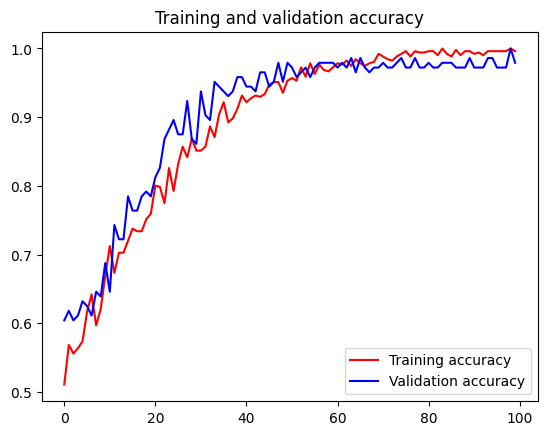

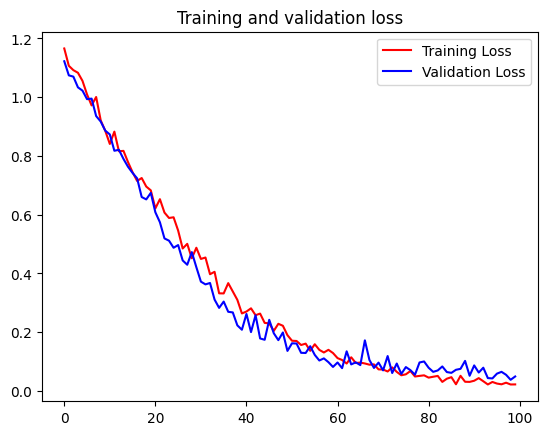

In [25]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**8- Saving the trained Model**

In [23]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "periapical_classifier_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [24]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
